In [55]:
# general imports
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
from matplotlib.colors import ListedColormap
import seaborn as sns

# from our documents
import OurFunctions as of

# from Scikit Learn library
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, make_scorer, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import LocalOutlierFactor

# from Imb Learn
from imblearn.over_sampling import SMOTENC

In [56]:
ASD_phenotypic_original = pd.read_csv(os.path.join('DataSets','Phenotypic Datasets','ASD_phenotypic.csv'))
ASD_phenotypic = pd.read_csv(os.path.join('DataSets','Phenotypic Datasets','ASD_phenotypic_preprocessed.csv'))
ASD_diagnosis = pd.read_csv(os.path.join('DataSets','Phenotypic Datasets','ASD_clinical.csv'))

# CLASSIFICATION

First of all, we split the data into train set and test set, to be sure that our classifier is evaluated on data that it had never seen before.

In [57]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(ASD_phenotypic, ASD_diagnosis['DX_GROUP'], test_size=0.3, random_state=42)
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (467, 11)
Test set size: (201, 11)


I want to check the balance between classes for each set, to  be sure we are training the classifier using a good split.

In [58]:
class_counts_test = y_test.value_counts(normalize=True)
class_counts_train = y_train.value_counts(normalize=True)
class_count_train_num = y_train.value_counts()

# Stampa il conteggio delle classi per DX_GROUP
print("Class proportions for:")
print("- test set: " + str(class_counts_test))
print("- train set: " + str(class_counts_train))
print("Num subjects involved per "+ str(class_count_train_num))

Class proportions for:
- test set: DX_GROUP
1    0.60199
2    0.39801
Name: proportion, dtype: float64
- train set: DX_GROUP
1    0.603854
2    0.396146
Name: proportion, dtype: float64
Num subjects involved per DX_GROUP
1    282
2    185
Name: count, dtype: int64


# General pipeline

To achieve a more reliable accuracy score we use k-fold cross validation. In this way we are performing the training on different train and validation fold and we avoid to have a better accuracy based only on the subjects we selected.

In [92]:
def general_pipeline(dataset, target, classifier, encoder = True, scaler = True, parameters_grid_search = None, cv = None, feature_selector=False):

    # Definizione delle metriche da utilizzare come scoring
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1_score': make_scorer(f1_score)
    }

    # Preprocess to make on the train data may include
    # - normalization of the numerical columns
    # - one hot encoding on the categorical columns
    
    categorical_columns = dataset.select_dtypes(include=['object']).columns

    if not encoder:
        transformers = [('num', RobustScaler(), ~dataset.columns.isin(categorical_columns))]
    elif not scaler:
        transformers = [('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)]
    elif not encoder and not scaler:
        transformers = []
    else:
        transformers=[
            ('num', RobustScaler(), ~dataset.columns.isin(categorical_columns)),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ]

    preprocessor = ColumnTransformer(transformers=transformers)

    if isinstance(classifier, KNeighborsClassifier):
        parameter_type = 'classifier__n_neighbors'
        if parameters_grid_search:
            parameters = {parameter_type: parameters_grid_search}  # Valori di n_neighbors da esplorare
        else:
            parameters = {parameter_type: [3, 5, 7, 9, 11]}  # Valori di n_neighbors da esplorare

    if isinstance(classifier, RandomForestClassifier):
        parameter_type = 'classifier__n_estimators'
        if parameters_grid_search:
            parameters = {parameter_type: parameters_grid_search}  # Valori di n_neighbors da esplorare
        else:
            parameters = {parameter_type: [10, 50, 200, 500, 1000]}  # Valori di n_neighbors da esplorare

    if isinstance(classifier, svm.SVC):
        parameter_type = 'classifier__C'
        if parameters_grid_search:
            parameters = {parameter_type: parameters_grid_search}  # Valori di n_neighbors da esplorare
        else:
            parameters = {parameter_type: [1]}  # Valori di n_neighbors da esplorare
    

    if feature_selector:
       
        pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('sfs', SFS(classifier)),
        ('classifier', classifier)  
        ])

        #parameters.update({'sfs__n_features_to_select': list(range(3,len(dataset)))})
        parameters.update({'sfs__n_features_to_select': list(range(3,4))})
        parameters.update({'sfs__direction': ['forward']})
        
    else:
    # We define the pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', classifier),
            ])

    if cv:
        k_folds = cv
    else:
        k_folds = 5

    # Creazione dell'oggetto GridSearchCV
    grid_search = GridSearchCV(pipeline, parameters, cv= k_folds, scoring=scoring, refit='accuracy')

    # Esecuzione della ricerca a griglia
    grid_search.fit(dataset, target)

    # Visualizzazione dei risultati
    print("Risultati della cross-validation per tutte le combinazioni di iperparametri:")

    means_accuracy = grid_search.cv_results_['mean_test_accuracy']
    stds_accuracy = grid_search.cv_results_['std_test_accuracy']
    means_precision = grid_search.cv_results_['mean_test_precision']
    means_recall = grid_search.cv_results_['mean_test_recall']
    means_f1_score = grid_search.cv_results_['mean_test_f1_score']
    params = grid_search.cv_results_['params']

    for mean_acc, std_acc, mean_prec, mean_rec, mean_f1, params in zip(means_accuracy, stds_accuracy, means_precision, means_recall, means_f1_score, params):
        print(f"Parametri: {params}, Accuratezza media: {mean_acc:.3f} (±{std_acc:.3f}), Precision media: {mean_prec:.3f}, Richiamo medio: {mean_rec:.3f}, F1-score medio: {mean_f1:.3f}")

    best_model = grid_search.best_estimator_
    best_parameter = grid_search.best_params_[parameter_type]
    best_accuracy = grid_search.best_score_
    print("\nMiglior parametro trovato:")
    print(best_parameter)
    print("Accuratezza media con il miglior parametro:", best_accuracy)

    if feature_selector:
        selected_mask = best_model.named_steps['sfs'].get_support()
        feature_names = dataset.columns
        selected_features = feature_names[selected_mask]
        print("\nLe features selezionate sono:")
        print(f"Numero di features selezionate: {len(selected_features)}")
        print("Features selezionate:", selected_features)
        return best_model, best_parameter, best_accuracy, selected_features
        
    return best_model, best_parameter, best_accuracy, None
    

In [60]:
categorical_columns = X_train.select_dtypes(include=['object']).columns
categorical_features = categorical_columns.tolist()

# Inizializza l'oggetto SMOTE-NC specificando gli indici delle colonne categoriche
sampler = SMOTENC(categorical_features=categorical_features, random_state=42)

# Applica SMOTE-NC per generare nuovi esempi sintetici
X_SMOTE, Y_SMOTE = sampler.fit_resample(X_train, y_train)

# Stampa la distribuzione delle classi dopo l'applicazione di SMOTE-NC
print(pd.Series(Y_SMOTE).value_counts(normalize=True))
print("Num subjects involved per")
print(pd.Series(Y_SMOTE).value_counts())

DX_GROUP
1    0.5
2    0.5
Name: proportion, dtype: float64
Num subjects involved per
DX_GROUP
1    282
2    282
Name: count, dtype: int64


# K-NEAREST NEIGHBOOR

In [79]:
classifier = KNeighborsClassifier()
knn_model, knn_parameter, knn_accuracy, _= general_pipeline(X_SMOTE, Y_SMOTE, classifier)


Risultati della cross-validation per tutte le combinazioni di iperparametri:
Parametri: {'classifier__n_neighbors': 3}, Accuratezza media: 0.887 (±0.030), Precision media: 0.959, Richiamo medio: 0.808, F1-score medio: 0.876
Parametri: {'classifier__n_neighbors': 5}, Accuratezza media: 0.885 (±0.039), Precision media: 0.963, Richiamo medio: 0.802, F1-score medio: 0.873
Parametri: {'classifier__n_neighbors': 7}, Accuratezza media: 0.887 (±0.039), Precision media: 0.976, Richiamo medio: 0.794, F1-score medio: 0.872
Parametri: {'classifier__n_neighbors': 9}, Accuratezza media: 0.888 (±0.032), Precision media: 0.983, Richiamo medio: 0.791, F1-score medio: 0.875
Parametri: {'classifier__n_neighbors': 11}, Accuratezza media: 0.883 (±0.028), Precision media: 0.983, Richiamo medio: 0.780, F1-score medio: 0.868

Miglior parametro trovato:
9
Accuratezza media con il miglior parametro: 0.8883217446270543


In [62]:
# Valutazione del modello sui dati di test
y_pred = knn_model.predict(X_test)

# Calcolo delle metriche sui dati di test
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nValutazione del modello sui dati di test:")
print(f"Accuratezza: {accuracy:.3f}")
print(f"Precisione: {precision:.3f}")
print(f"Richiamo: {recall:.3f}")
print(f"F1-score: {f1:.3f}")



Valutazione del modello sui dati di test:
Accuratezza: 0.841
Precisione: 0.949
Richiamo: 0.777
F1-score: 0.855


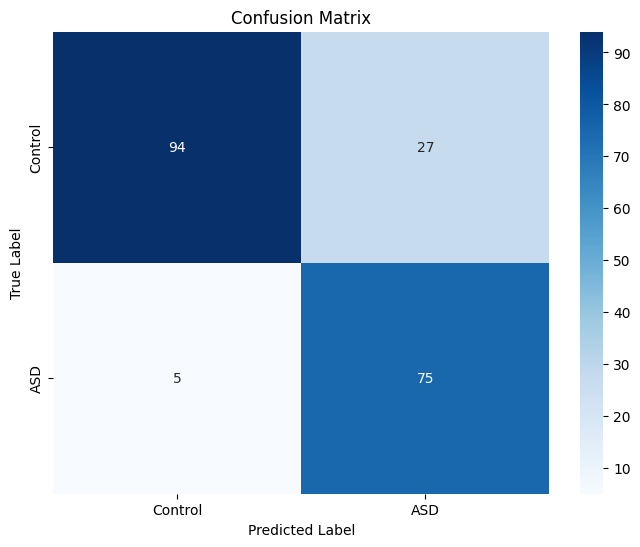

In [63]:
# Calcola la matrice di confusione
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['Control', 'ASD'], yticklabels=['Control', 'ASD'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


## Random Forest

To use the Random Forest classifier, I need to have only numerical features, so we will use one-hot-encoding to turn the categorical features (which aren't ordinal) into numerical features. It's not necessary to perform any normalization, but as we want to compare the performance of this classifier with others that use normalization, we will also use normalized data to train this classifier (it's not harmfull for the Random Forest Classifier).

In [76]:
classifier = RandomForestClassifier(random_state=1234)
rf_model, rf_parameter, rf_accuracy, _ = general_pipeline(X_SMOTE, Y_SMOTE, classifier)

Risultati della cross-validation per tutte le combinazioni di iperparametri:
Parametri: {'classifier__n_estimators': 10}, Accuratezza media: 0.934 (±0.017), Precision media: 0.935, Richiamo medio: 0.936, F1-score medio: 0.935
Parametri: {'classifier__n_estimators': 50}, Accuratezza media: 0.934 (±0.020), Precision media: 0.954, Richiamo medio: 0.915, F1-score medio: 0.933
Parametri: {'classifier__n_estimators': 200}, Accuratezza media: 0.942 (±0.020), Precision media: 0.964, Richiamo medio: 0.918, F1-score medio: 0.940
Parametri: {'classifier__n_estimators': 500}, Accuratezza media: 0.943 (±0.018), Precision media: 0.968, Richiamo medio: 0.918, F1-score medio: 0.942
Parametri: {'classifier__n_estimators': 1000}, Accuratezza media: 0.942 (±0.020), Precision media: 0.967, Richiamo medio: 0.915, F1-score medio: 0.940

Miglior parametro trovato:
500
Accuratezza media con il miglior parametro: 0.9432838179519596


In [66]:
# Valutazione del modello sui dati di test
y_pred = rf_model.predict(X_test)

# Calcolo delle metriche sui dati di test
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nValutazione del modello sui dati di test:")
print(f"Accuratezza: {accuracy:.3f}")
print(f"Precisione: {precision:.3f}")
print(f"Richiamo: {recall:.3f}")
print(f"F1-score: {f1:.3f}")



Valutazione del modello sui dati di test:
Accuratezza: 0.975
Precisione: 0.983
Richiamo: 0.975
F1-score: 0.979


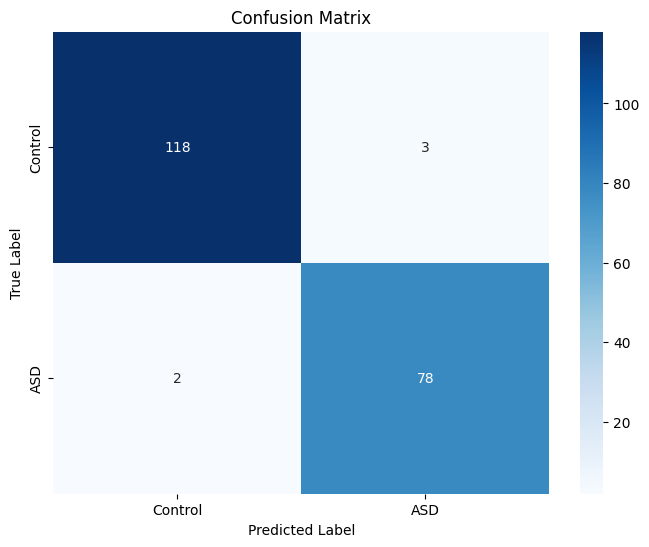

In [67]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['Control', 'ASD'], yticklabels=['Control', 'ASD'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Support vector machine

In [68]:
classifier = svm.SVC(probability=True)
svc_model, svc_parameter, svc_accuracy, _ = general_pipeline(X_SMOTE, Y_SMOTE, classifier)

Risultati della cross-validation per tutte le combinazioni di iperparametri:
Parametri: {'classifier__C': 1}, Accuratezza media: 0.918 (±0.024), Precision media: 0.978, Richiamo medio: 0.858, F1-score medio: 0.912

Miglior parametro trovato:
1
Accuratezza media con il miglior parametro: 0.9184576485461442


In [69]:
# Valutazione del modello sui dati di test
y_pred = svc_model.predict(X_test)

# Calcolo delle metriche sui dati di test
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nValutazione del modello sui dati di test:")
print(f"Accuratezza: {accuracy:.3f}")
print(f"Precisione: {precision:.3f}")
print(f"Richiamo: {recall:.3f}")
print(f"F1-score: {f1:.3f}")



Valutazione del modello sui dati di test:
Accuratezza: 0.935
Precisione: 0.982
Richiamo: 0.909
F1-score: 0.944


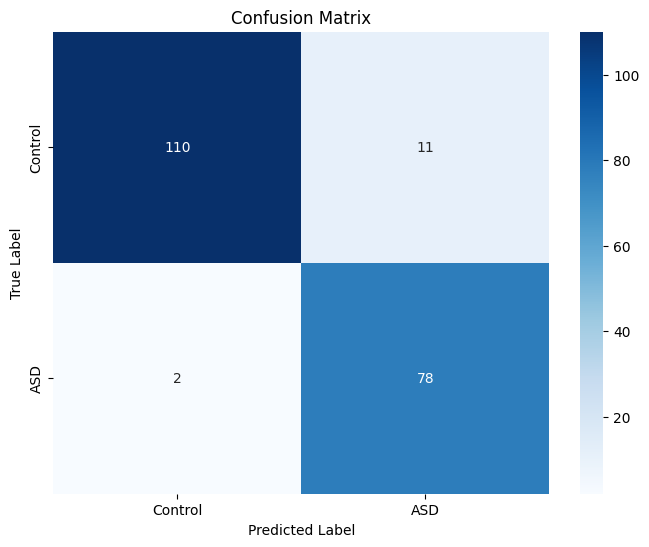

In [70]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['Control', 'ASD'], yticklabels=['Control', 'ASD'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Comparison Between Classifiers

In [71]:
# Define a function to evaluate the AUC-ROC for a given model
def evaluate_roc_auc(model, X_test, y_test):
    y_proba = model.predict_proba(X_test)[:, 1]
    auc_roc = roc_auc_score(y_test, y_proba)
    return auc_roc

knn_auc_roc = evaluate_roc_auc(knn_model, X_test, y_test)
rf_auc_roc = evaluate_roc_auc(rf_model, X_test, y_test)
svc_auc_roc = evaluate_roc_auc(svc_model, X_test, y_test)

# Print the results
print("K-Nearest Neighbors Classifier AUC-ROC:", knn_auc_roc)
print("Random Forest Classifier AUC-ROC:", rf_auc_roc)
print("Support vector Classifier AUC-ROC:", svc_auc_roc)


K-Nearest Neighbors Classifier AUC-ROC: 0.959142561983471
Random Forest Classifier AUC-ROC: 0.9934917355371901
Support vector Classifier AUC-ROC: 0.9829545454545454


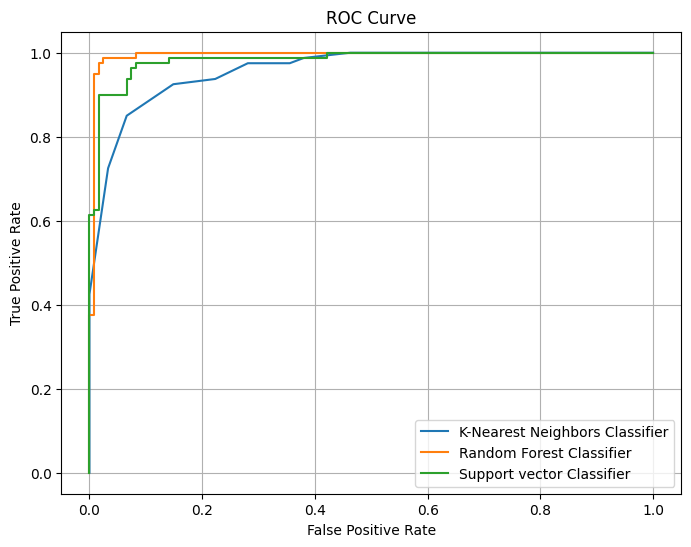

In [72]:
# Define a function to plot the ROC curve for a given model
def plot_roc_curve(model, X_test, y_test, model_name):
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=model_name)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)

# Plot ROC curve for both models
y_test_binary = (y_test == 2).astype(int)

plt.figure(figsize=(8, 6))
plot_roc_curve(knn_model, X_test, y_test_binary, 'K-Nearest Neighbors Classifier')
plot_roc_curve(rf_model, X_test, y_test_binary, 'Random Forest Classifier')
plot_roc_curve(svc_model, X_test, y_test_binary, 'Support vector Classifier')
plt.show()


# Feature selection

In [93]:
classifier = KNeighborsClassifier()

fs_KNN = general_pipeline(X_SMOTE, Y_SMOTE, classifier, parameters_grid_search = [9], feature_selector=True)

Risultati della cross-validation per tutte le combinazioni di iperparametri:
Parametri: {'classifier__n_neighbors': 9, 'sfs__direction': 'forward', 'sfs__n_features_to_select': 3}, Accuratezza media: 0.901 (±0.024), Precision media: 0.972, Richiamo medio: 0.826, F1-score medio: 0.892

Miglior parametro trovato:
9
Accuratezza media con il miglior parametro: 0.9006795195954489


IndexError: boolean index did not match indexed array along dimension 0; dimension is 11 but corresponding boolean dimension is 35

In [ ]:
classifier = RandomForestClassifier(random_state=1234)

fs_RF = general_pipeline(X_SMOTE, Y_SMOTE, classifier, feature_selector=True)

In [ ]:
classifier = svm.SVC()

fs_SVM = general_pipeline(X_SMOTE, Y_SMOTE, classifier, feature_selector=True)

# Outliers detection

In [ ]:
ASD_phenotypic_outliers = ASD_phenotypic.select_dtypes(include=[np.number])
X = ASD_phenotypic_outliers.values

# Initialize Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.02)  # Adjust parameters as needed

# Fit the model and predict outliers
outliers = lof.fit_predict(X)

# outliers == -1 indicates outliers, 1 indicates inliers
ASD_phenotypic_outliers['outlier'] = outliers


# Print number of detected outliers
print(f"Number of outliers detected: {np.sum(outliers == -1)}")

Number of outliers detected: 14


In [ ]:
outlier_subjects = ASD_phenotypic_outliers[ASD_phenotypic_outliers['outlier'] == -1]

pd.set_option('display.max_columns', None); outlier_subjects.T


,0,48,242,280,375,484,537,568,573,604,616,633,645,665
AGE_AT_SCAN,55.4,7.61,64.0,8.7912,14.98,9.200000,26.1465,16.7584,37.7769,32.8487,14.420000,15.750000,16.420000,11.080000
SEX,1.0,1.00,1.0,1.0000,1.00,1.000000,1.0000,1.0000,1.0000,1.0000,2.000000,2.000000,1.000000,1.000000
FIQ,126.0,129.00,120.0,127.0000,64.00,147.500000,148.0000,94.0000,65.0000,106.0000,129.357143,108.928571,58.642857,74.357143
VIQ,118.0,108.00,119.0,149.0000,59.00,168.768116,137.0000,72.0000,55.0000,87.0000,111.925926,91.555556,54.888889,73.629630
PIQ,128.0,146.00,116.0,101.0000,73.00,115.000000,155.0000,124.0000,76.0000,128.0000,107.000000,82.000000,37.000000,60.000000
ADI_R_VERBAL_TOTAL_BV,8.0,20.00,8.0,20.0000,23.00,22.000000,7.0000,8.0000,8.0000,8.0000,9.000000,9.000000,9.000000,24.000000
ADOS_TOTAL,9.0,11.00,7.0,11.0000,16.00,11.000000,0.0000,17.0000,17.0000,16.0000,8.000000,11.000000,6.000000,8.000000
outlier,-1.0,-1.00,-1.0,-1.0000,-1.00,-1.000000,-1.0000,-1.0000,-1.0000,-1.0000,-1.000000,-1.000000,-1.000000,-1.000000


In [ ]:
ASD_phenotypic.describe()

,AGE_AT_SCAN,SEX,FIQ,VIQ,PIQ,ADI_R_VERBAL_TOTAL_BV,ADOS_TOTAL
count,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000
mean,16.276463,1.118263,107.519140,106.976190,106.287425,11.835329,9.670659
std,7.183633,0.323162,15.330938,15.782631,16.113020,5.010616,3.752370
min,6.470000,1.000000,58.642857,54.888889,37.000000,4.000000,0.000000
25%,11.658575,1.000000,97.000000,97.000000,96.000000,8.000000,7.000000
50%,14.260000,1.000000,107.428571,108.000000,107.000000,9.000000,9.000000
75%,18.495100,1.000000,119.000000,118.000000,118.000000,16.000000,11.000000
max,64.000000,2.000000,148.000000,168.768116,157.000000,26.000000,22.000000


In [ ]:
outlier_subjects.describe()

,AGE_AT_SCAN,SEX,FIQ,VIQ,PIQ,ADI_R_VERBAL_TOTAL_BV,ADOS_TOTAL,outlier
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.0
mean,23.655836,1.142857,106.984694,100.340580,103.428571,13.071429,10.571429,-1.0
std,17.746103,0.363137,30.916485,36.001469,33.797392,6.844024,4.831217,0.0
min,7.610000,1.000000,58.642857,54.888889,37.000000,7.000000,0.000000,-1.0
25%,11.915000,1.000000,79.267857,72.407407,77.500000,8.000000,8.000000,-1.0
50%,16.085000,1.000000,114.464286,99.777778,111.000000,9.000000,11.000000,-1.0
75%,31.173150,1.000000,128.500000,118.750000,127.000000,20.000000,14.750000,-1.0
max,64.000000,2.000000,148.000000,168.768116,155.000000,24.000000,17.000000,-1.0


C:\Users\auran\AppData\Local\Temp\ipykernel_11788\2746287251.py:15: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(outliers[:, 0], outliers[:, 1], c='blue', edgecolor='k', marker='x', s=100, label='Outliers')  # Highlight outliers


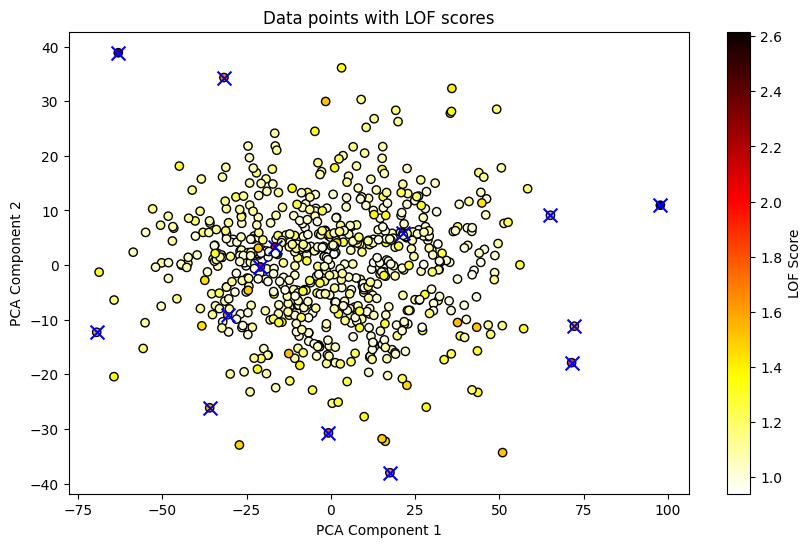

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)
outliers = X_reduced[ASD_phenotypic_outliers['outlier'] == -1]

lof_scores = lof.negative_outlier_factor_

# Plot the data points with color indicating LOF scores
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=-lof_scores, cmap='hot_r', edgecolor='k', label='Inliers')
plt.colorbar(label='LOF Score')
plt.scatter(outliers[:, 0], outliers[:, 1], c='blue', edgecolor='k', marker='x', s=100, label='Outliers')  # Highlight outliers
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Data points with LOF scores')
plt.show()


Let's see the changes in the data distribution per each feature

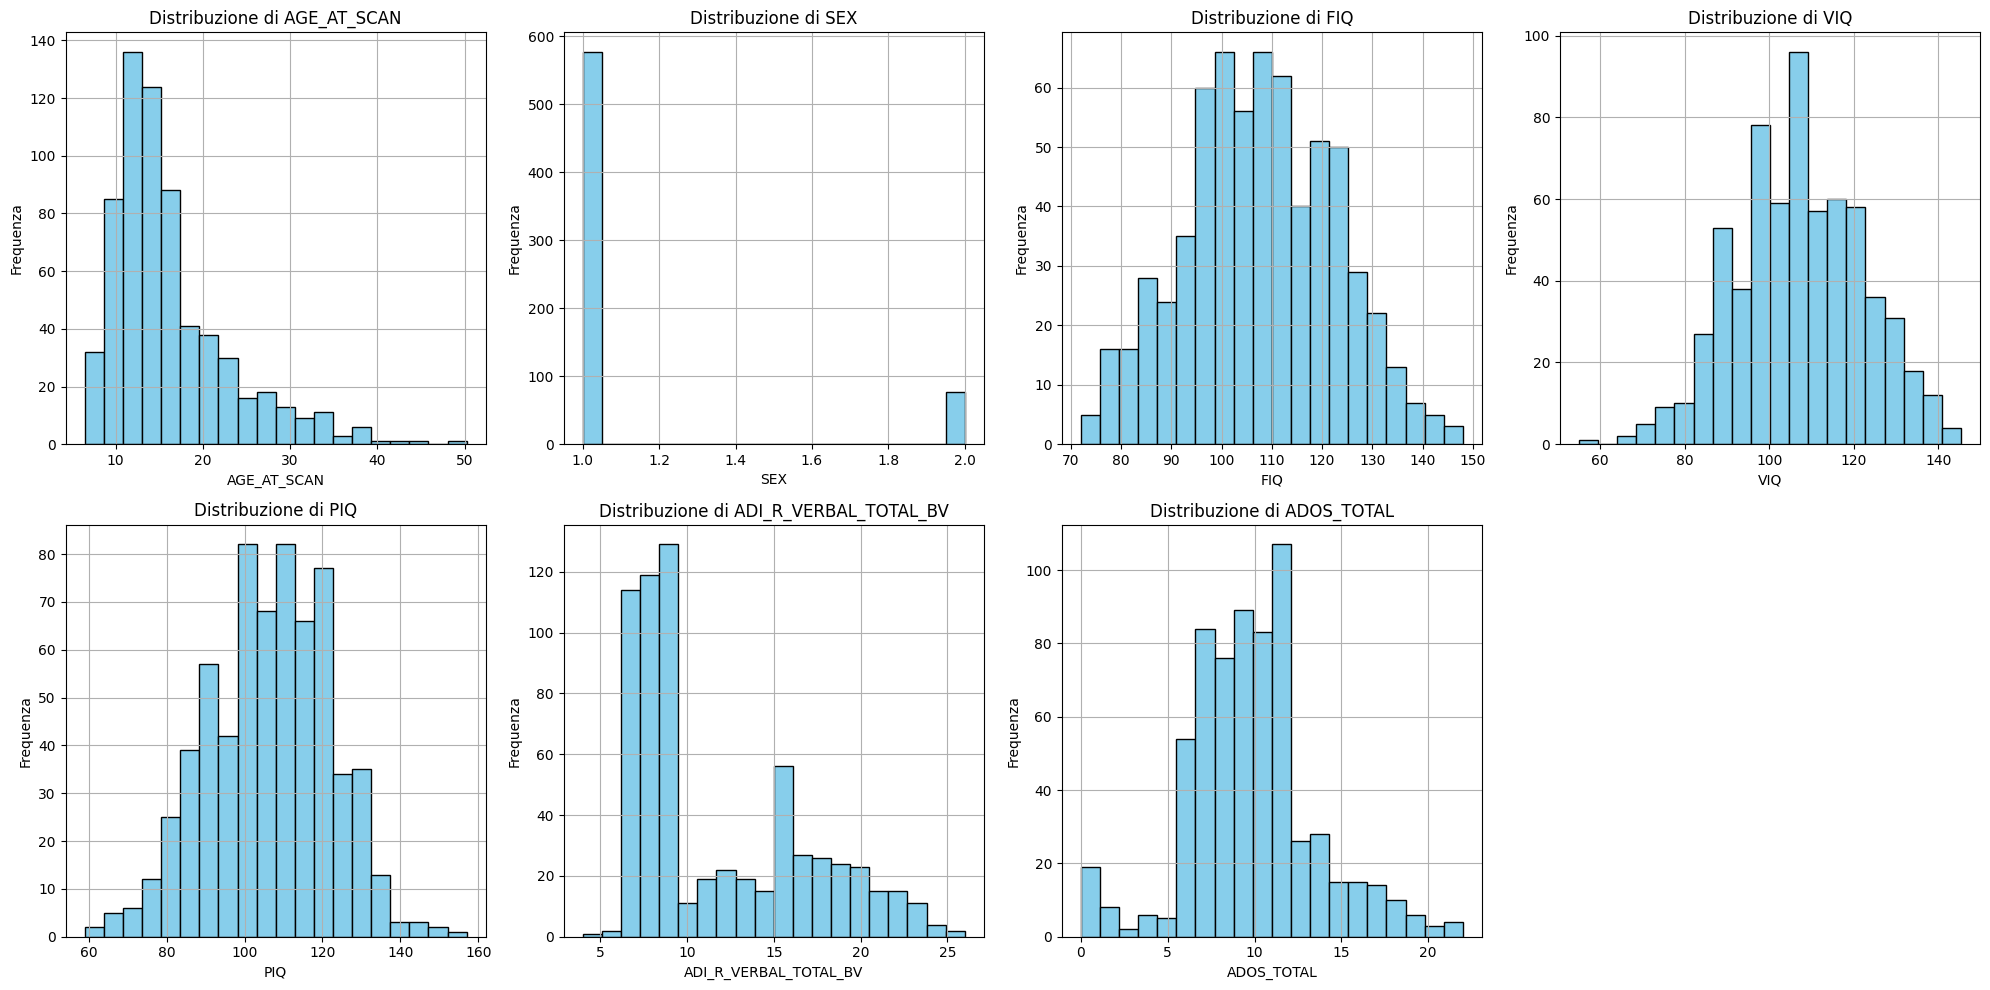

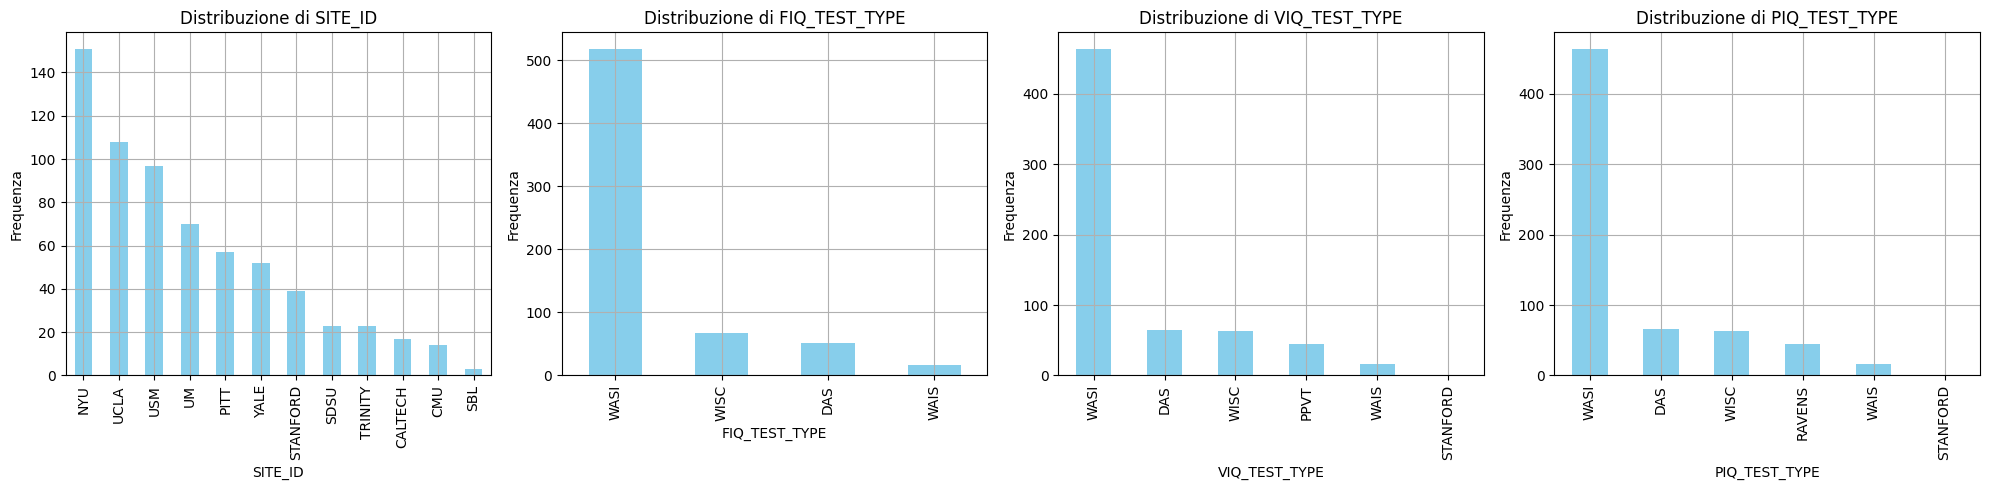

In [ ]:
ASD_phenotypic_without_outliers = ASD_phenotypic[ASD_phenotypic_outliers['outlier'] == 1]
ASD_diagnosis_without_outliers = ASD_diagnosis[ASD_phenotypic_outliers['outlier'] == 1]
of.plot_distributions(ASD_phenotypic_without_outliers)

let's see if this make a better training

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(ASD_phenotypic_without_outliers, ASD_diagnosis_without_outliers['DX_GROUP'], test_size=0.3, random_state=42)

categorical_columns = X_train.select_dtypes(include=['category']).columns
categorical_features = categorical_columns.tolist()

# Inizializza l'oggetto SMOTE-NC specificando gli indici delle colonne categoriche
sampler = SMOTENC(categorical_features=categorical_features, random_state=42)

# Applica SMOTE-NC per generare nuovi esempi sintetici
X_SMOTE, Y_SMOTE = sampler.fit_resample(X_train, y_train)
sampler = SMOTENC(categorical_features=categorical_features, random_state=42)

# Applica SMOTE-NC per generare nuovi esempi sintetici
X_SMOTE, Y_SMOTE = sampler.fit_resample(X_train, y_train)

In [ ]:
knn_model = general_pipeline(X_SMOTE, Y_SMOTE, KNeighborsClassifier())
rf_model = general_pipeline(X_SMOTE, Y_SMOTE, RandomForestClassifier(random_state=1234))
svc_model = general_pipeline(X_SMOTE, Y_SMOTE, svm.SVC(probability=True))

Risultati della cross-validation per tutte le combinazioni di iperparametri:
Parametri: {'classifier__n_neighbors': 3}, Accuratezza media: 0.910 (±0.035), Precision media: 0.966, Richiamo medio: 0.851, F1-score medio: 0.904
Parametri: {'classifier__n_neighbors': 5}, Accuratezza media: 0.912 (±0.024), Precision media: 0.974, Richiamo medio: 0.847, F1-score medio: 0.906
Parametri: {'classifier__n_neighbors': 7}, Accuratezza media: 0.897 (±0.026), Precision media: 0.965, Richiamo medio: 0.825, F1-score medio: 0.889
Parametri: {'classifier__n_neighbors': 9}, Accuratezza media: 0.888 (±0.023), Precision media: 0.965, Richiamo medio: 0.806, F1-score medio: 0.878
Parametri: {'classifier__n_neighbors': 11}, Accuratezza media: 0.875 (±0.030), Precision media: 0.951, Richiamo medio: 0.791, F1-score medio: 0.863

Miglior parametro trovato:
5
Accuratezza media con il miglior parametro: 0.912374524056767
Risultati della cross-validation per tutte le combinazioni di iperparametri:
Parametri: {'class

# Find best sensibility

In [ ]:
def outlier_detector(dataset, diagnosis, contamination_factor):
    dataset_outliers = dataset.select_dtypes(include=[np.number])
    X = dataset_outliers.values

    # Initialize Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=10, contamination=contamination_factor)  # Adjust parameters as needed

    # Fit the model and predict outliers
    outliers = lof.fit_predict(X)

    # Print number of detected outliers
    print(f"Number of outliers detected: {np.sum(outliers == -1)}")

    # outliers == -1 indicates outliers, 1 indicates inliers
    #ASD_phenotypic_outliers['outlier'] = outliers

   # outlier_subjects = ASD_phenotypic_outliers[ASD_phenotypic_outliers['outlier'] == -1]

    #pd.set_option('display.max_columns', None); outlier_subjects.T

    dataset_without_outliers = dataset[outliers == 1]
    diagnosis_without_outliers = ASD_diagnosis[ASD_phenotypic_outliers['outlier'] == 1]

    return dataset_without_outliers, diagnosis_without_outliers

In [ ]:
ASD_phenotypic_without_outliers, ASD_diagnosis_without_outliers = outlier_detector(ASD_phenotypic, ASD_diagnosis)

X_train, X_test, y_train, y_test = train_test_split(ASD_phenotypic_without_outliers, ASD_diagnosis_without_outliers['DX_GROUP'], test_size=0.3, random_state=42)

categorical_columns = X_train.select_dtypes(include=['category']).columns
categorical_features = categorical_columns.tolist()

# Inizializza l'oggetto SMOTE-NC specificando gli indici delle colonne categoriche
sampler = SMOTENC(categorical_features=categorical_features, random_state=42)

# Applica SMOTE-NC per generare nuovi esempi sintetici
X_SMOTE, Y_SMOTE = sampler.fit_resample(X_train, y_train)
sampler = SMOTENC(categorical_features=categorical_features, random_state=42)

# Applica SMOTE-NC per generare nuovi esempi sintetici
X_SMOTE, Y_SMOTE = sampler.fit_resample(X_train, y_train)

In [ ]:
knn_model = general_pipeline(X_SMOTE, Y_SMOTE, KNeighborsClassifier())
rf_model = general_pipeline(X_SMOTE, Y_SMOTE, RandomForestClassifier(random_state=1234))
svc_model = general_pipeline(X_SMOTE, Y_SMOTE, svm.SVC(probability=True))